In [199]:
import xml.etree.ElementTree as etree
import pandas as pd
import numpy as np
import re
from gensim import corpora, models

from sklearn import model_selection, pipeline, preprocessing, metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
# from sklearn.decomposition import TruncatedSVD

import scipy.sparse as sps

from collections import Counter

from nltk.corpus import stopwords

from pymystem3 import Mystem
import jamspell
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool

from natasha import OrganisationExtractor, LocationExtractor
import pickle

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# Изучение датасета

In [200]:
def read_xml_as_pd(doc): 
    tree = etree.parse(doc)
    root = tree.getroot()
    root = root[1]
    data = []
    for tweet in root:
        row = {}
        for feature in tweet:
            row[feature.attrib["name"]] = feature.text
        data.append(row)
    return data

In [201]:
train_banks = "Corpuses/SentiRuEval/bank_train_2016.xml"
test_banks = "Corpuses/SentiRuEval/banks_test_etalon.xml"

X_train_banks = pd.DataFrame.from_dict(read_xml_as_pd(train_banks))[["text"]].values.flatten()
y_train_banks = pd.DataFrame.from_dict(read_xml_as_pd(train_banks)).drop(["id", "twitid", "date", "text"], 1)
X_test_banks = pd.DataFrame.from_dict(read_xml_as_pd(test_banks))[["text"]].values.flatten()
y_test_banks = pd.DataFrame.from_dict(read_xml_as_pd(test_banks)).drop(["id", "twitid", "date", "text"], 1)

In [202]:
print(X_test_banks[:10])

['#Автокредит в россельхозбанк в череповце'
 'RT @thomasabiloxuz: http://t.co/GTfMwSQQ2c #Кредитный калькулятор россельхозбанк 2012'
 '#Автокредит в россельхозбанк 2012 http://t.co/9jc1OCzyv2'
 'RT @ronaldisogacoq: #Кредитные карты россельхозбанк http://t.co/BZTF5Cuk4W'
 'RT @anthonyogihulaf: #Кредиты в россельхозбанке ижевск http://t.co/GdqH1k0GlC'
 '#Аккредитация страховых компаний в россельхозбанке'
 'RT @74Emtsov: #Россельхозбанк саранск кредитные программа гараж http://t.co/HNENQPRAJ9'
 '#Автокредит г барнаул россельхозбанк http://t.co/Bo5GAYm9ZO'
 'http://t.co/AFunnXczvo #Автокредит калькулятор россельхозбанк'
 'http://t.co/dVvbEAStbh #Автокредит в нальчике россельхозбанк']


In [203]:
train_tkk = "Corpuses/SentiRuEval/tkk_train_2016.xml"
test_tkk = "Corpuses/SentiRuEval/tkk_test_etalon.xml"

X_train_tkk = pd.DataFrame.from_dict(read_xml_as_pd(train_tkk))[["text"]].values.flatten()
y_train_tkk = pd.DataFrame.from_dict(read_xml_as_pd(train_tkk)).drop(["id", "twitid", "date", "text"], 1)
X_test_tkk = pd.DataFrame.from_dict(read_xml_as_pd(test_tkk))[["text"]].values.flatten()
y_test_tkk = pd.DataFrame.from_dict(read_xml_as_pd(test_tkk)).drop(["id", "twitid", "date", "text"], 1)

In [204]:
# Объем доступных данных
print(X_train_banks.shape, y_train_banks.shape, X_test_banks.shape,  y_test_banks.shape)
print(X_train_tkk.shape, y_train_tkk.shape, X_test_tkk.shape,  y_test_tkk.shape)

(9392,) (9392, 8) (3313,) (3313, 8)
(8643,) (8643, 7) (2247,) (2247, 7)


In [205]:
# Вывод: все твиты имеют отношение хотя бы к одной из компаний
# Вывод: есть твиты, которые имеют отношение к нескольким компаниям!!!

In [206]:
y_test_banks.describe()
# У компаний м/б только значения "NULL", 0, -1, 1

,alfabank,bankmoskvy,gazprom,raiffeisen,rshb,sberbank,uralsib,vtb
count,3313,3313,3313,3313,3313,3313,3313,3313
unique,4,4,4,4,4,4,3,4
top,NULL,NULL,NULL,NULL,NULL,0,NULL,NULL
freq,3162,3275,3194,3001,3093,1449,3304,3068


In [207]:
# Еще немного статистики
a = []
for column in y_test_banks.columns:
    a.append(y_test_banks[column].value_counts())
stat = pd.DataFrame(a)
stat["NotNULL"] = np.sum(stat, 1) - stat["NULL"]
stat

,-1,0,1,NULL,NotNULL
alfabank,59.0,77.0,15.0,3162.0,151.0
bankmoskvy,10.0,23.0,5.0,3275.0,38.0
gazprom,4.0,110.0,5.0,3194.0,119.0
raiffeisen,16.0,284.0,12.0,3001.0,312.0
rshb,4.0,199.0,17.0,3093.0,220.0
sberbank,645.0,1449.0,230.0,989.0,2324.0
uralsib,1.0,8.0,NaN,3304.0,9.0
vtb,45.0,166.0,34.0,3068.0,245.0


In [208]:
# Еще немного статистики
a = []
for column in y_test_banks.columns:
    a.append(y_test_banks[column].value_counts())
stat = pd.DataFrame(a)
stat["NotNULL"] = np.sum(stat, 1) - stat["NULL"]
stat

,-1,0,1,NULL,NotNULL
alfabank,59.0,77.0,15.0,3162.0,151.0
bankmoskvy,10.0,23.0,5.0,3275.0,38.0
gazprom,4.0,110.0,5.0,3194.0,119.0
raiffeisen,16.0,284.0,12.0,3001.0,312.0
rshb,4.0,199.0,17.0,3093.0,220.0
sberbank,645.0,1449.0,230.0,989.0,2324.0
uralsib,1.0,8.0,NaN,3304.0,9.0
vtb,45.0,166.0,34.0,3068.0,245.0


In [209]:
# Чтобы упростить задачу будем "наивно" относить каждый твит только к одному сентименту

def naivelabeling(df):
    y_naive = np.array([0] * df.shape[0])
    distr = np.array(np.matrix([np.sum(df == "0", 1), np.sum(df == "-1", 1), np.sum(df == "1", 1)]).T)
    for itr, comb in enumerate(distr):
        if comb[0] >= comb[1] and comb[0] >= comb[2]:
            y_naive[itr] = 0
        elif comb[1] >= comb[2]:
            y_naive[itr] = -1
        else:
            y_naive[itr] = 1
    return y_naive

y_train_banks_naive = naivelabeling(y_train_banks)
y_test_banks_naive = naivelabeling(y_test_banks)

# F-measure

In [210]:
# В роли бейзлайна возьмем на каждом объекте самый популярный в выборке ответ,
# то есть -1 для обеих выборок

y_predict_tkk = np.array([-1] * X_test_tkk.shape[0])
y_predict_banks = np.array([-1] * X_test_banks.shape[0])

In [211]:
# f-мера для такого бейзлайна, если считать наивные верные ответы за истинные
metrics.f1_score(y_test_banks_naive, y_predict_banks, labels = [-1, 1], average="micro")

0.35111719106247147

In [212]:
# Напишем функцию, которая будет считать f-меру для ВСЕХ упоминаний компаний в твитах
def f_measure(y_true, prediction):
    """y_true - pd.DataFrame (NxM),
    prediction - np.array(N,)
    
    returns (macro f1-score, micro f1-score)"""
    
    fill_value = pd.DataFrame({col: prediction for col in y_true.columns})
    prediction = y_true[y_true == "NULL"].fillna(fill_value, axis = 1)
    y_true = [int(x) for x in y_true.values.flatten() if x != "NULL"]
    prediction = [int(x) for x in prediction.values.flatten() if x != "NULL"]
    f_macro = metrics.f1_score(y_true, prediction, labels = [-1, 1], average="macro")
    f_micro = metrics.f1_score(y_true, prediction, labels = [-1, 1], average="micro")
    return f_macro, f_micro

In [213]:
print("Значения полной f-меры для ТКК и банков:")
print(f_measure(y_test_tkk, y_predict_tkk), f_measure(y_test_banks, y_predict_banks))
print("\nЛюбопытства ради посмотрим, насколько наивное предсказание отличается \n\
от истинного, по сути - это лучший результат, который можно получить:")
print(f_measure(y_test_tkk, naivelabeling(y_test_tkk)), f_measure(y_test_banks, y_test_banks_naive))

Значения полной f-меры для ТКК и банков:
(0.3217535153019024, 0.6049766718506999) (0.1865778200856735, 0.34690265486725663)

Любопытства ради посмотрим, насколько наивное предсказание отличается 
от истинного, по сути - это лучший результат, который можно получить:
(0.9383921593645832, 0.9677419354838709) (0.9888615964842706, 0.9909173478655767)


/home/vasinkd/venv/python3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


__Будем работать с выборкой по банкам, т.к. в ней почти нет пересекающихся сентиментов__

In [214]:
# Эта функция считает твит положительным или отрицательным, если в нем есть хотя бы
# один положительный или отрицательный сентимент

# Именно такой подход использовали организаторы соревнования

def f_measure2(y_true, prediction):
    """y_true - pd.DataFrame (NxM),
    prediction - np.array(N,)
    
    returns (macro f1-score, micro f1-score)"""
    
    positive_tweets_true = np.sum(y_true == "1", 1) > 0
    positive_tweets_prediction = prediction == 1
    
    negative_tweets_true = np.sum(y_true == "-1", 1) > 0
    negative_tweets_prediction = prediction == -1
    
    TN_pos, FP_pos, FN_pos, TP_pos = metrics.confusion_matrix(positive_tweets_true, 
                                                              positive_tweets_prediction).flatten()
    TN_neg, FP_neg, FN_neg, TP_neg = metrics.confusion_matrix(negative_tweets_true, 
                                                              negative_tweets_prediction).flatten()
    
    micro_precision = (TP_pos + TP_neg)/(TP_pos + TP_neg + FP_pos + FP_neg)
    micro_recall = (TP_pos + TP_neg)/(TP_pos + TP_neg + FN_pos + FN_neg)
    micro_f1 = (2*micro_precision*micro_recall)/(micro_precision + micro_recall)
    
    precision_pos = np.nan_to_num((TP_pos)/(TP_pos + FP_pos))
    precision_neg = np.nan_to_num((TP_neg)/(TP_neg + FP_neg))
    macro_precision = (precision_pos + precision_neg)/2
    
    recall_pos = np.nan_to_num((TP_pos)/(TP_pos + FN_pos))
    recall_neg = np.nan_to_num((TP_neg)/(TP_neg + FN_neg))
    macro_recall = (recall_pos + recall_neg)/2
    
    macro_f1 = (2*macro_precision*macro_recall)/(macro_precision+macro_recall)
    
    return macro_f1, micro_f1

In [215]:
print("Значения данной f-меры для ТКК и банков:")
print(f_measure2(y_test_tkk, y_predict_tkk), f_measure2(y_test_banks, y_predict_banks))
print("\nЛюбопытства ради посмотрим, насколько наивное предсказание отличается \n\
от истинного, по сути - это лучший результат, который можно получить:")
print(f_measure2(y_test_tkk, naivelabeling(y_test_tkk)), f_measure2(y_test_banks, y_test_banks_naive))

Значения данной f-меры для ТКК и банков:
(0.3192971826719176, 0.5976750779699461) (0.18898408812729497, 0.35114851034796457)

Любопытства ради посмотрим, насколько наивное предсказание отличается 
от истинного, по сути - это лучший результат, который можно получить:
(0.9506662848835928, 0.980891719745223) (0.9920785367262137, 0.9949003245248029)


/home/vasinkd/venv/python3.5/lib/python3.5/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


# Предобработка

In [216]:
def parsing_prob(x):
    # убираем твиттеровское форматирование
    x = re.sub("&[^;]*;[^;]*;", '', x)
    x = re.sub("&[^;]*;", '', x)
    # Если пробелов больше одного - оставляем один
    x = re.sub('[\s]+', ' ', x)
    return x

def normal(x):
    # приводим все к строчному виду
    x = x.lower()
    # убираем все ссылки
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',x)
    # Убираем все упоминания пользователей
    x = re.sub('@[^\s]+','',x)
    # убираем хэштеги
    x = re.sub('#', '', x)
    # Убираем все, что начинается с цифр
    x = re.sub(" \d[^\s]*", '', x)
    x = re.sub("\d+", '', x)
    # Если символ встречается больше 2 раз подряд, то заменяем 1 символом
    x = re.sub(r"(.)\1{2,}", r'\1', x)
    # Убираем всю пунктуацию 
    x = re.sub("[^\w']", " ", x)
    # Убираем, что осталось от твиттерского форматирования:
    x = re.sub("(?:^|\W)rt(?:$|\W)", "", x)
    x = re.sub("(?:^|\W)r(?:$|\W)", "", x)
    x = re.sub("(?:^|\W)г(?:$|\W)", "", x)
    # Если пробелов больше одного - оставляем один
    x = re.sub('[\s]+', ' ', x)
    # убираем пробелы в начале и в конце
    x = x.strip()
    return x

X_train_banks = [parsing_prob(x) for x in X_train_banks]
X_test_banks = [parsing_prob(x) for x in X_test_banks]

X_train_banks_pr = [normal(x) for x in X_train_banks]
X_test_banks_pr = [normal(x) for x in X_test_banks]

## Лемматизация

В лемматизации нет объединения не со следующим словом!

In [217]:
def lemmat(txt):
    corrector = jamspell.TSpellCorrector()
    corrector.LoadLangModel('ru_small.bin')
    mystem = Mystem()
    s0 = ""
    for s in tqdm(txt):
        s = corrector.FixFragment(s)
        s0 = s0 + " ?&$ " + s
    
    lem_list = ''.join(mystem.lemmatize(s0))

    return lem_list.split(" ?&$ ")[1:]

# pool = Pool()

# X_train_banks_lm, X_test_banks_lm, X_train_banks_pr_lm, X_test_banks_pr_lm = \
# pool.map(lemmat, [X_train_banks, X_test_banks, X_train_banks_pr, X_test_banks_pr])
     
# pd.DataFrame(X_train_banks_lm).to_csv("X_train_banks_lm.txt", index = False)
# pd.DataFrame(X_test_banks_lm).to_csv("X_test_banks_lm.txt", index = False)
# pd.DataFrame(X_train_banks_pr_lm).to_csv("X_train_banks_pr_lm.txt", index = False)
# pd.DataFrame(X_test_banks_pr_lm).to_csv("X_test_banks_pr_lm.txt", index = False)

In [218]:
X_test_banks_lm = [item for sublist in pd.read_csv("Corpuses/SentiRuEval/X_test_banks_lm.txt").values for item in sublist]
X_train_banks_lm = [item for sublist in pd.read_csv("Corpuses/SentiRuEval/X_train_banks_lm.txt").values for item in sublist]
X_train_banks_pr_lm = [item for sublist in pd.read_csv("Corpuses/SentiRuEval/X_train_banks_pr_lm.txt").values for item in sublist]
X_test_banks_pr_lm = [item for sublist in pd.read_csv("Corpuses/SentiRuEval/X_test_banks_pr_lm.txt").values for item in sublist]

In [219]:
len(X_train_banks_lm), len(X_train_banks_pr_lm), len(X_train_banks), len(X_test_banks_lm), len(X_test_banks_pr_lm), len(X_test_banks)

(9392, 9392, 9392, 3313, 3313, 3313)

In [220]:
# Авторские стоп-слова.

extractor = LocationExtractor()

def extract_loc(text):
    matches = extractor.parser.extract(text)
    return [match.fact.name for match in matches]

pool = Pool()
res = pool.map(extract_loc, X_train_banks_pr_lm + X_test_banks_pr_lm)

organisations = Counter()
for matches in res:
    for match in matches:
        organisations[match] += 1
        
locations = [x[0] for x in organisations.most_common() if x[1]>1]

bank_names = ["альфа", "альфабанк", "альфа банк", "альфабанка", "банк москвы", "банк москва", "рсхб", "россельхозбанк", "россельхоз банк", "банк", "банка", "втб", "райффайзенбанк",  "райфайзенбанк",  "райффайзен банк", "райффайзен", "райфайзен", "сбербанк", "сбер", "газпром", "газпромбанк", "северо", "запад", "уралсиб", 'открытый акционерный общество', "филиал", "sberbank", "cib"]

author_stop_words = locations + bank_names

Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-18:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-17:
Traceback (most recent call last):
Process ForkPoolWorker-23:
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
Process ForkPoolWorker-21:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Process ForkPoolWorker-24:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*se

In [196]:
#Классические стоп-слова
with open("stop_words.txt", "r", encoding="cp1251") as fout:
        stop_words = fout.read().split(" ?&$ ")[:-1]
stop_words.pop(stop_words.index("не"));

# Extra features

## LDA Features (check stability effects)

LDA будем строить с помощью библиотеки gensim.
В качестве слов, которые будут отброшены из словаря были взяты стоп-слова для русского языка из NLTK, а также названия банков, т.к. они не несут в себе информацию о теме документа.

Так же была идея отбросить слишком часто встречающиеся слова, но при таком подходе из словаря были убраны слова, очень важные для определения темы, например "санкция", которое встречается в обучающей коллекции 700 раз.

In [547]:
X_train_lda_texts = [x.split() for x in X_train_banks_pr_lm]
X_test_lda_texts = [x.split() for x in X_test_banks_pr_lm]

In [695]:
scores = []

for i in tqdm(range(30)):
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_train_banks_pr_lm, y_train_banks_naive, test_size = 0.15, stratify=y_train_banks_naive)

    # Подготовка
    X_train_lda_dictionary = corpora.Dictionary(X_train_lda_texts) 

    # Исключение из словаря слов, которые не несут в себе информацию о теме документа
    bad_ids = [X_train_lda_dictionary.token2id[x] for x in author_stop_words + stop_words if x in X_train_lda_dictionary.token2id]

    X_train_lda_dictionary.filter_tokens(bad_ids=bad_ids)
    X_train_lda_dictionary.filter_extremes(no_below = 2, no_above = .5)
    X_train_lda_dictionary.filter_n_most_frequent(50)

    lda_train_corpus = [X_train_lda_dictionary.doc2bow(text.split()) for text in X_train_lda]
    lda_test_corpus = [X_train_lda_dictionary.doc2bow(text.split()) for text in X_test_lda]

    # Обучение

    ldamodel = models.ldamulticore.LdaMulticore(lda_train_corpus, alpha = 0.0001, 
                                                eta = 'auto', id2word=X_train_lda_dictionary, 
                                                num_topics=num, passes=10, workers=7)
    lda_train_features = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                           in list(lda_train_corpus)]).applymap(lambda x: round(x[1], 2))

    lda_test_features = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                           in list(lda_test_corpus)]).applymap(lambda x: round(x[1], 2))

    estimator = RandomForestClassifier(n_estimators=200, n_jobs=7)
    estimator.fit(lda_train_features, y_train_lda)
    y_predict = estimator.predict(lda_test_features)
    score = {}
    score["test"] = metrics.f1_score(y_test_lda, y_predict, average='macro')
    score["perplexity"] = ldamodel.log_perplexity(lda_test_corpus)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=[text.split() for text in X_train_lda], dictionary=X_train_lda_dictionary, coherence='c_v')
    score["coherence"] = coherence_model_lda.get_coherence()    

    # print("Test macro f1 score: {}".format(metrics.f1_score(y_test_lda, y_predict, average='macro')))

    ldamodel.update(lda_test_corpus)

    X_train_banks_lda = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                               in list(X_train_lda_corpus)]).applymap(lambda x: round(x[1], 2))
    X_test_banks_lda = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                           in list(X_test_lda_corpus)]).applymap(lambda x: round(x[1], 2))

    estimator = RandomForestClassifier(n_estimators=200, n_jobs=7)
    estimator.fit(X_train_banks_lda, y_train_banks_naive)
    y_predict = estimator.predict(X_test_banks_lda)
    score["validation"] = f_measure2(y_test_banks, y_predict)[0]
    scores.append(score)
    # print("Validation macro f1 score: %s" % f_measure2(y_test_banks, y_predict)[0])









  0%|          | 0/30 [00:00<?, ?it/s]







  3%|▎         | 1/30 [00:18<08:43, 18.04s/it]







  7%|▋         | 2/30 [00:36<08:32, 18.31s/it]







 10%|█         | 3/30 [00:56<08:30, 18.92s/it]







 13%|█▎        | 4/30 [01:16<08:20, 19.25s/it]







 17%|█▋        | 5/30 [01:37<08:05, 19.41s/it]







 20%|██        | 6/30 [01:58<07:52, 19.69s/it]







 23%|██▎       | 7/30 [02:18<07:34, 19.76s/it]







 27%|██▋       | 8/30 [02:38<07:16, 19.84s/it]







 30%|███       | 9/30 [02:59<06:57, 19.90s/it]







 33%|███▎      | 10/30 [03:20<06:40, 20.01s/it]







 37%|███▋      | 11/30 [03:40<06:20, 20.03s/it]







 40%|████      | 12/30 [04:00<06:00, 20.03s/it]







 43%|████▎     | 13/30 [04:20<05:40, 20.05s/it]







 47%|████▋     | 14/30 [04:40<05:20, 20.06s/it]







 50%|█████     | 15/30 [05:00<05:00, 20.05s/it]







 53%|█████▎    | 16/30 [05:20<04:40, 20.03s/it]







 57%|█████▋    | 17/30 [05:40<04:20, 20.04s/it]







 60%|██████    | 18/

In [696]:
scores = sorted(scores, key = lambda x: x["validation"], reverse=True)
scores

[{'coherence': 0.6286252759760068,
  'perplexity': -12.166463824147998,
  'test': 0.3871540446771635,
  'validation': 0.244884193707033},
 {'coherence': 0.6362521623114114,
  'perplexity': -12.107560286562965,
  'test': 0.3926451584642005,
  'validation': 0.1973052016493977},
 {'coherence': 0.6566827680639061,
  'perplexity': -12.013797314752901,
  'test': 0.37819806208422296,
  'validation': 0.19098044321853166},
 {'coherence': 0.6422531549268456,
  'perplexity': -12.13878293301816,
  'test': 0.38425194691971476,
  'validation': 0.18733773174676518},
 {'coherence': 0.6432010258708332,
  'perplexity': -12.104618313644671,
  'test': 0.40310796055892717,
  'validation': 0.18430933286018628},
 {'coherence': 0.638256213235123,
  'perplexity': -12.142647157348327,
  'test': 0.39627049387987207,
  'validation': 0.1839320125852185},
 {'coherence': 0.6268224925260641,
  'perplexity': -12.316735255930334,
  'test': 0.3664090627950129,
  'validation': 0.1817408722595824},
 {'coherence': 0.657218

In [698]:
test_scores = scale([x["test"] for x in scores])
validation_scores = scale([x["validation"] for x in scores])
perplexity_scores = scale([x["perplexity"] for x in scores])
coherence_scores = scale([x["coherence"] for x in scores])

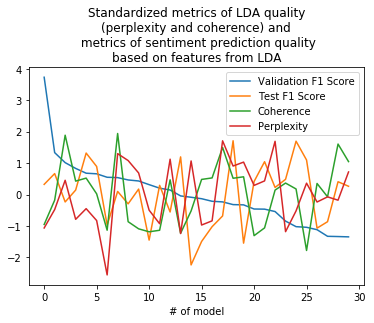

In [721]:
plt.plot(range(len(validation_scores)), validation_scores, label="Validation F1 Score")
plt.plot(range(len(validation_scores)), test_scores, label="Test F1 Score")
plt.plot(range(len(validation_scores)), coherence_scores, label="Coherence")
plt.plot(range(len(validation_scores)), perplexity_scores, label="Perplexity")
plt.legend()
plt.title("Standardized metrics of LDA quality\n(perplexity and coherence) and\n standardized metrics of sentiment prediction quality\nbased on features from LDA")
plt.xlabel("# of model");

In [707]:
pearsonr(test_scores, validation_scores), pearsonr(perplexity_scores, validation_scores), pearsonr(coherence_scores, validation_scores)

((0.015821930833737296, 0.9338650836916045),
 (-0.23207320075095217, 0.21718869001101535),
 (-0.14645321009806736, 0.43996621994132623))

__Вывод:__ качество модели на валидационной выборке, построенной на базе признаков, полученных с помоью LDA, не зависит ни от качества модели на тестовой выборке, ни от внутренних критериев качества моделей LDA.

__Выдвигаем следующую гипотезу:__ качество моделей, построенных на большем количестве признаков, среди которых есть признаки, полученные с помощью LDA, в незначительной степени зависит от инициализации моделей LDA.

## LDA Features

In [487]:
# Подготовка
lda_stop_words = author_stop_words + stop_words #+ ["не"]#+ ["кредит", "ипотечный", "бизнес", "млрд", "рубль"]

X_train_lda_texts = [[word for word in x.split() if word not in lda_stop_words] for x in X_train_banks_pr_lm]
# X_train_lda_texts = [[" ".join(x) for x in ngrams(doc, 2)] + doc for doc in X_train_lda_texts0]
X_train_lda_dictionary = corpora.Dictionary(X_train_lda_texts) 
X_train_lda_corpus = [X_train_lda_dictionary.doc2bow(text) for text in X_train_lda_texts]

# Исключение из словаря слов, которые не несут в себе информацию о теме документа
stop_words_ids = [X_train_lda_dictionary.token2id[x] for x in ["не"] if x in list(X_train_lda_dictionary.values())]
banks_ids = [X_train_lda_dictionary.token2id[x] for x in stop_words if x in X_train_lda_dictionary.token2id]

bad_ids = stop_words_ids + banks_ids
# bad_ids = [key for key in X_train_lda_dictionary.dfs.keys() if X_train_lda_dictionary.dfs[key] > 700]# + banks_ids

# X_train_lda_dictionary.filter_tokens(bad_ids=bad_ids)
X_train_lda_dictionary.filter_extremes(no_below = 2, no_above = .5)
X_train_lda_dictionary.filter_n_most_frequent(50)
X_train_lda_corpus = [X_train_lda_dictionary.doc2bow(text) for text in X_train_lda_texts]

X_test_lda_texts = [x.split() for x in X_test_banks_pr_lm]

X_test_lda_texts = [[word for word in x.split() if word not in lda_stop_words] for x in X_test_banks_pr_lm]
# X_test_lda_texts = [[" ".join(x) for x in ngrams(doc, 2)] + doc for doc in X_test_lda_texts0]

X_test_lda_corpus = [X_train_lda_dictionary.doc2bow(text) for text in X_test_lda_texts]

Были построены модели, выделяющие 5, 10 и 20 тем.  
В качестве параметра alpha, характеризующего степень разреженность матрицы темы-документы было выбрано значение 0.0001, т. к. особенности Твиттера подразумевают, что одно пользовательское сообщение должно содержать в себе одну тему.

In [465]:
num_topics = [5, 10, 20]
num_topics = [10]

X_train_banks_lda = {} 
X_test_banks_lda = {} 

for num in num_topics:
    ldamodel = models.ldamulticore.LdaMulticore(X_train_lda_corpus, alpha = 0.0001, 
                                                eta = 'auto', id2word=X_train_lda_dictionary, 
                                                num_topics=num, passes=10)
    X_train_banks_lda[num] = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                           in list(X_train_lda_corpus)]).applymap(lambda x: round(x[1], 2))
#     ldamodel.   update(X_test_lda_corpus)
    X_test_banks_lda[num] = pd.DataFrame([ldamodel.get_document_topics(x,  minimum_probability=0) for x \
                                           in list(X_test_lda_corpus)]).applymap(lambda x: round(x[1], 2))

In [ ]:
# def saveLDAtofiles(txt, name, num_topics):
#     for num in num_topics:
#         txt[num].to_csv("Corpuses/SentiRuEval/"+name+str(num)+".csv", sep = ";", index = False)
# saveLDAtofiles(X_train_banks_lda, "X_train_banks_lda", num_topics)
# saveLDAtofiles(X_test_banks_lda, "X_test_banks_lda", num_topics)

In [ ]:
def readLDAfiles(name, num_topics):
    test = {}
    for num in num_topics:
        test[num] = pd.read_csv('Corpuses/SentiRuEval/'+name+str(num)+".csv", sep = ";")
        test[num].columns = list(map(lambda x: 'lda_topic_'+ str(x), list(range(1, num+1))))
    return test

X_test_banks_lda = readLDAfiles("X_test_banks_lda", num_topics)
X_train_banks_lda = readLDAfiles("X_train_banks_lda", num_topics)

In [ ]:
X_train_banks_lda[20].shape

## Sentiment dictionary

In [ ]:
# my_cols = ["word", "POS", "lemma", "sentiment", "source", "ambiguity"]
# val_dict = pd.read_table("rusentilex_2017.txt", sep = ",", names = my_cols, skipinitialspace=True)

Словарь был очищен от ошибок

In [ ]:
# val_dict.loc[val_dict[val_dict.sentiment.isin(['posiive', 'posititve', 
#                                                'postitive', "postive"])].index, "sentiment"] = "positive"
# val_dict.loc[val_dict[val_dict.sentiment.isin(['negative ', 'negaitve'])].index, "sentiment"] = "negative"

# val_dict.loc[val_dict[val_dict.source.isin(['opinion ', 'opinion  ', 'opinon', 'opinegativenion',
#                                             'opinion    ', 'opinion                     '])].index, "source"] = "opinion"
# val_dict.loc[val_dict[val_dict.source.isin(['fact ', 'fact В ТЕЗ EMPTY',
#                                            'fact В ТЕЗ empty', 'factg'])].index, "source"] = "fact"
# val_dict.loc[val_dict[val_dict.source.isin(['feeling ', 'feeling  ',
#                                            'feeeling'])].index, "source"] = "feeling"
# val_dict.loc[val_dict[val_dict.source.isin(['operator '])].index, "source"] = 'operator'

In [ ]:
# val_dict.sentiment.unique()

In [ ]:
# val_dict.head(5)

Каждой тональности сопоставлена бинарная переменная. Также каждому слову/словосочетанию сопоставлены бинарные переменные, отвечающие за эмоциональное или неэмоциональное происхождение слова.  
Параметры для многозначных слов были усреднены. Таким образом, для каждого слова в словаре сумма по строке столбцов, отвечающих за тональность = 1, так же как и сумма столбцов, отвечающих за происхождение слова.

In [ ]:
# grouped = pd.get_dummies(val_dict[["lemma", "sentiment", "source"]], columns=["sentiment", "source"])
# grouped["emotional"] = grouped[["source_feeling", "source_opinion"]].sum(axis=1)
# grouped["not_emotional"] = grouped[["source_fact", "source_operator"]].sum(axis=1)
# grouped.drop(["source_feeling", "source_opinion", "source_fact", "source_operator"], axis = 1, inplace=True)

# grouped = grouped.groupby("lemma", as_index=False).mean()
# grouped["lemma"] = grouped.lemma.apply(lambda x: x.lower().split("/"))

In [ ]:
# grouped.head(5)

Части слов в словаре было сопоставленно несколько его лемматизированных форм, поэтому для каждой из этих форм были продумлированы показатели, вычисленные для порождающего эту лемму слова

In [ ]:
# def separate_lemmas(grouped):
#     valence_df = pd.DataFrame(columns=grouped.columns)
#     for i in tqdm(range(grouped.shape[0])):
#         df = pd.DataFrame(columns=grouped.columns)
#         a = grouped.iloc[i,0]
#         b = grouped.iloc[i, 1:]
#         df.lemma = a
#         for el in range(len(a)):
#             df.iloc[el, 1:] = b
#         valence_df = pd.concat([valence_df, df])
#     return valence_df
    
# grouped = separate_lemmas(grouped=grouped)

Было вычислено чило слов в каждой лемме, леммы с числом слов больше 3 были удалены из словаря, т.к. таких словосочетаний в словаре очень мало (около 1%), но их учет значительно увеличивает время работы алгоритма

In [ ]:
# grouped["words_count"] = list(map(lambda x: len(x.split()), grouped.lemma.values))
# sum(grouped['words_count'] > 3)/grouped.shape[0]

In [ ]:
# grouped = grouped[grouped['words_count'] <= 3].reset_index().drop(["index"], axis = 1)

In [ ]:
# grouped.to_csv("valence_df.csv", index=False)
# grouped = pd.read_csv("valence_df.csv")

Из словаря тональности был создан словарь, где каждой лемме был сопоставлен ее номер в датафрейме grouped. Предложения, для которых нужно оценить тональность, векторизуются с помощью CountVectorizer c ключами из словаря тональности. Получилась очень разреженная матрица. Из нее с помощью np.nonzero получаем набор индексов, где первый набор - номер предложения, а второй - номер слова из словаря тональности, которое присутствует в данном предложении. Каждому предложению сопостовляем 6 параметров: 'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',                                                           'sentiment_positive/negative', 'emotional', 'not_emotional'. Если в предложении нет слов из словаря, то значения для него равны нулю по каждому из шести столбцов. Если же слова/словосочетания есть, то значения из словаря тональности каждого слова/словосочетания из предложения прибавляются взвешенные на отношение длины слова/словосочетания на длину предложения.  

Ключ отвечает за отображение самых популярных слов в датасете среди присутствующих в словаре тональности.

In [ ]:
# rev_my_vocab = grouped["lemma"].to_dict()
# my_vocab = {v : k for k, v in rev_my_vocab.items()} 

In [ ]:
# def valence_dataset(data, verbose=False):
#     vectorizer = CountVectorizer(ngram_range=(1,3), vocabulary=my_vocab)
#     vectorized_list = vectorizer.fit_transform(data)
#     contain_valence = np.nonzero(vectorized_list)
#     map_sent_valence = list(zip(contain_valence[0], list(contain_valence[1])))
#     result = pd.DataFrame(np.zeros((len(data), 6)), columns = ['sentiment_negative', 'sentiment_neutral', 'sentiment_positive', \
#                                                                    'sentiment_positive/negative', 'emotional', 'not_emotional'])
#     if verbose:
#         print(Counter(list(map(lambda x: rev_my_vocab[x], contain_valence[1]))).most_common(20))
#     for tup in map_sent_valence:
#             result.iloc[tup[0], :] += grouped.iloc[tup[1], 1:7] * grouped.iloc[tup[1], 7] / len(data[tup[0]].split())
#     return result

# X_train_banks_valence = valence_dataset(X_train_banks_pr_lm, True)
# print()
# X_test_banks_valence = valence_dataset(X_test_banks_pr_lm, True)

# [('санкция', 700), ('потребительский', 350), ('вклад', 103), ('отзыв', 92), ('образец', 81), ('очередь', 63), ('помощь', 63), ('хороший', 60), ('поддержка', 48), ('признавать', 48), ('помогать', 44), ('долг', 36), ('операция', 34), ('мастер', 33), ('не работать', 33), ('льготный', 27), ('ошибка', 23), ('нужда', 23), ('сожаление', 22), ('надежный', 22)]

# [('потребительский', 83), ('долг', 79), ('признавать', 69), ('шок', 64), ('банкрот', 60), ('иск', 58), ('банкротство', 51), ('кризис', 50), ('очередь', 49), ('помощь', 34), ('вклад', 32), ('убыток', 30), ('проблема', 29), ('поддержка', 23), ('не работать', 23), ('падение', 22), ('лидер', 22), ('льготный', 21), ('отказ', 21), ('хороший', 20)]


In [ ]:
# X_train_banks_valence.to_csv("Corpuses/SentiRuEval/X_train_banks_valence.csv", index=False)
# X_test_banks_valence.to_csv("Corpuses/SentiRuEval/X_test_banks_valence.csv", index=False)

X_train_banks_valence = pd.read_csv("Corpuses/SentiRuEval/X_train_banks_valence.csv")
X_test_banks_valence = pd.read_csv("Corpuses/SentiRuEval/X_test_banks_valence.csv")

# Final model

In [1]:
# Результаты поиска по сетке будем сохранять в файлы в папку grid_results
def save_grid(grid_res, name):
    df = pd.DataFrame(grid_res.cv_results_).drop(['mean_fit_time', 'mean_score_time', 'mean_train_score',
                                      'rank_test_score', 'split0_test_score', 'split0_train_score', 
                                       'split1_test_score', 'split1_train_score', 'split2_test_score', 
                                       'split2_train_score', 'std_fit_time', 'std_score_time', 'std_train_score'], 1, errors="ignore")
    df.sort_values("mean_test_score", 0, ascending = False).reset_index().drop(["index"], 1).to_csv("grid_results/"+name+".csv", sep=";", encoding="utf-8")

def read_grid(
    name):
    return pd.read_csv("grid_results/"+name+".csv", sep=";", encoding="utf-8", index_col=0)

In [186]:
# Класс для выбора нужных признаков при предобработке

class ColumnExtractor(object):

    def __init__(self, rng):
        self.rng = rng

    def transform(self, X):
        if hasattr(X, "values"):
            X = X.values
        if self.rng[1] == "end":
            return X[:, self.rng[0]:]
        elif self.rng[1] == self.rng[0]:
            return X[:, self.rng[0]]
        else:
            return X[:, self.rng[0]:self.rng[1]+1]

    def fit(self, X, y=None):
        return self
        
    def get_params(self, deep=True):
        return {'rng' : self.rng}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.rng = value
        return self

In [ ]:
scorer = metrics.make_scorer(metrics.f1_score, labels = [-1, 1], average = "macro")
cv = model_selection.KFold(n_splits=3, shuffle=True)

## Feature union

In [ ]:
# X_train_short_lda5_valence = pd.concat([pd.DataFrame(X_train_banks_pr_lm, columns = [["text"]]), 
#                                         X_train_banks_valence, X_train_banks_lda[5]], axis=1)
# X_train_short_lda10_valence = pd.concat([pd.DataFrame(X_train_banks_pr_lm, columns = [["text"]]), 
#                                         X_train_banks_valence, X_train_banks_lda[10]], axis=1)
# X_train_short_lda20_valence = pd.concat([pd.DataFrame(X_train_banks_pr_lm, columns = [["text"]]), 
#                                         X_train_banks_valence, X_train_banks_lda[20]], axis=1)

# X_test_short_lda5_valence = pd.concat([pd.DataFrame(X_test_banks_pr_lm, columns = [["text"]]), 
#                                         X_test_banks_valence, X_test_banks_lda[5]], axis=1)
# X_test_short_lda10_valence = pd.concat([pd.DataFrame(X_test_banks_pr_lm, columns = [["text"]]), 
#                                         X_test_banks_valence, X_test_banks_lda[10]], axis=1)
# X_test_short_lda20_valence = pd.concat([pd.DataFrame(X_test_banks_pr_lm, columns = [["text"]]), 
#                                         X_test_banks_valence, X_test_banks_lda[20]], axis=1)

In [221]:
# X_train_short_lda5_valence.to_csv("X_train_short_lda5_valence.csv", index=False)
# X_train_short_lda10_valence.to_csv("X_train_short_lda10_valence.csv", index=False)
# X_train_short_lda20_valence.to_csv("X_train_short_lda20_valence.csv", index=False)

# X_test_short_lda5_valence.to_csv("X_test_short_lda5_valence.csv", index=False)
# X_test_short_lda10_valence.to_csv("X_test_short_lda10_valence.csv", index=False)
# X_test_short_lda20_valence.to_csv("X_test_short_lda20_valence.csv", index=False)

X_train_short_lda5_valence = pd.read_csv("X_train_short_lda5_valence.csv")
X_train_short_lda10_valence = pd.read_csv("X_train_short_lda10_valence.csv")
X_train_short_lda20_valence = pd.read_csv("X_train_short_lda20_valence.csv")

X_test_short_lda5_valence = pd.read_csv("X_test_short_lda5_valence.csv")
X_test_short_lda10_valence = pd.read_csv("X_test_short_lda10_valence.csv")
X_test_short_lda20_valence = pd.read_csv("X_test_short_lda20_valence.csv")

### Linear SVM

In [188]:
def return_sparse(x):
    return sps.csr_matrix(x)

# estimator = pipeline.Pipeline(steps = [       
#     ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                               
#             #text
#             ('text_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([0, 0])),
#                 ('vectorization', TfidfVectorizer()),
#                         ])),
#             #non-text
#             ('nontext_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([1,"end"])),
#                 ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
#                             ]))
        
#         ])),
#        ('classifier', LinearSVC(random_state=42))
#     ]
# )

# parameters_grid = [{
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'feature_processing__nontext_processing__selecting__rng' : [None, [1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# ]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_short_lda5 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1)
# grid_short_lda5.fit(X_train_short_lda5_valence, y_train_banks_naive)

# save_grid(grid_short_lda5, "FINAL_LINEAR_SVC_LDA5_RUN1")

In [ ]:
# grid_short_lda10 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1)
# grid_short_lda10.fit(X_train_short_lda10_valence, y_train_banks_naive)
# save_grid(grid_short_lda10, "FINAL_LINEAR_SVC_LDA10_RUN1")

In [ ]:
# grid_short_lda20 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1)
# grid_short_lda20.fit(X_train_short_lda20_valence, y_train_banks_naive)
# save_grid(grid_short_lda20, "FINAL_LINEAR_SVC_LDA20_RUN1")

In [ ]:
# estimator = pipeline.Pipeline(steps = [('vectorization', CountVectorizer()), ('classifier', LinearSVC(random_state = 42))])

# parameters_grid = [{
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [None],
#     'vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_s = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_s.fit(X_train_banks_pr_lm, y_train_banks_naive)
# save_grid(grid_s, "FINAL_LINEARSVC_BASE_RUN1")

### Logistic Regression

In [ ]:
# def return_sparse(x):
#     return sps.csr_matrix(x)

# estimator = pipeline.Pipeline(steps = [       
#     ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                               
#             #text
#             ('text_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([0, 0])),
#                 ('vectorization', TfidfVectorizer()),
#                         ])),
#             #non-text
#             ('nontext_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([1,"end"])),
#                 ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
#                             ]))
        
#         ])),
#        ('classifier', LogisticRegression(random_state = 42, solver = "newton-cg", max_iter=500))
#     ]
# )

# parameters_grid = [{
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)

# # grid_short_lda5 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# # grid_short_lda5.fit(X_train_short_lda5_valence, y_train_banks_naive)
# # save_grid(grid_short_lda5, "FINAL_LOGISTIC_LDA5_RUN1")

# grid_short_lda10 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda10.fit(X_train_short_lda10_valence, y_train_banks_naive)
# save_grid(grid_short_lda10, "FINAL_LOGISTIC_LDA10_RUN1")

# grid_short_lda20 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda20.fit(X_train_short_lda20_valence, y_train_banks_naive)
# save_grid(grid_short_lda20, "FINAL_LOGISTIC_LDA20_RUN1")

In [ ]:
# estimator = pipeline.Pipeline(steps = [('vectorization', CountVectorizer()),
#                               ('classifier', LogisticRegression(random_state = 42, solver = "newton-cg", max_iter=500))])

# parameters_grid = [{
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [None],
#     'vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_s = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_s.fit(X_train_banks_pr_lm, y_train_banks_naive)
# save_grid(grid_s, "FINAL_LOGISTIC_BASE_RUN1")

### NaiveBayes

In [ ]:
# def return_sparse(x):
#     return sps.csr_matrix(x)

# estimator = pipeline.Pipeline(steps = [       
#     ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                               
#             #text
#             ('text_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([0, 0])),
#                 ('vectorization', TfidfVectorizer()),
#                         ])),
#             #non-text
#             ('nontext_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([1,"end"])),
#                 ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
#                             ]))
        
#         ])),
#        ('classifier', MultinomialNB())
#     ]
# )

# parameters_grid = [{
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [1]
# },
# {
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [2]
# }]

# cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True)

# grid_short_lda5 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda5.fit(X_train_short_lda5_valence, y_train_banks_naive)
# save_grid(grid_short_lda5, "FINAL_NB_LDA5_RUN1")

# grid_short_lda10 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda10.fit(X_train_short_lda10_valence, y_train_banks_naive)
# save_grid(grid_short_lda10, "  FINAL_NB_LDA10_RUN1")

# grid_short_lda20 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda20.fit(X_train_short_lda20_valence, y_train_banks_naive)
# save_grid(grid_short_lda20, "FINAL_NB_LDA20_RUN1")

In [ ]:
# estimator = pipeline.Pipeline(steps = [('vectorization', CountVectorizer()),
#                               ('classifier', MultinomialNB())])

# parameters_grid = [{
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'vectorization__min_df' : [1]
# },
# {
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [None],
#     'vectorization__min_df' : [2]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_s = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)

# grid_s.fit(X_train_banks_pr_lm, y_train_banks_naive)
# save_grid(grid_s, "FINAL_NB_BASE_RUN1")

### RF

In [ ]:
# def return_sparse(x):
#     return sps.csr_matrix(x)

# estimator = pipeline.Pipeline(steps = [       
#     ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                               
#             #text
#             ('text_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([0, 0])),
#                 ('vectorization', TfidfVectorizer()),
#                         ])),
#             #non-text
#             ('nontext_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([1,"end"])),
#                 ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
#                             ]))
        
#         ])),
#        ('classifier', RandomForestClassifier(n_estimators = 200, random_state = 42))
#     ]
# )

# parameters_grid = [{
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [1],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [2],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)

# grid_short_lda5 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=7, return_train_score=False)
# grid_short_lda5.fit(X_train_short_lda5_valence, y_train_banks_naive)
# save_grid(grid_short_lda5, "FINAL_RF_LDA5_RUN1")

# grid_short_lda10 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=7, return_train_score=False)
# grid_short_lda10.fit(X_train_short_lda10_valence, y_train_banks_naive)
# save_grid(grid_short_lda10, "FINAL_RF_LDA10_RUN1")

# grid_short_lda20 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=7, return_train_score=False)
# grid_short_lda20.fit(X_train_short_lda20_valence, y_train_banks_naive)
# save_grid(grid_short_lda20, "FINAL_RF_LDA20_RUN1")

In [ ]:
# estimator = pipeline.Pipeline(steps = [('vectorization', CountVectorizer()),
#                               ('classifier', RandomForestClassifier(n_estimators = 200, random_state = 42))])

# parameters_grid = [{
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'vectorization__min_df' : [1],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [None],
#     'vectorization__min_df' : [2],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_s = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)

# grid_s.fit(X_train_banks_pr_lm, y_train_banks_naive)
# save_grid(grid_s, "FINAL_RF_BASE_RUN1")

### SVC

In [ ]:
# def return_sparse(x):
#     return sps.csr_matrix(x)

# estimator = pipeline.Pipeline(steps = [       
#     ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
                               
#             #text
#             ('text_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([0, 0])),
#                 ('vectorization', TfidfVectorizer()),
#                         ])),
#             #non-text
#             ('nontext_processing', pipeline.Pipeline(steps = [
#                 ('selecting', ColumnExtractor([1,"end"])),
#                 ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
#                             ]))
        
#         ])),
#        ('classifier', SVC(random_state = 42))
#     ]
# )

# parameters_grid = [{
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'feature_processing__text_processing__vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'feature_processing__text_processing__vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'feature_processing__text_processing__vectorization__stop_words' : [None],
#     'feature_processing__nontext_processing__selecting__rng' : [[1, 6], [7, "end"], [1, "end"]],
#     'feature_processing__text_processing__vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)

# grid_short_lda5 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda5.fit(X_train_short_lda5_valence, y_train_banks_naive)
# save_grid(grid_short_lda5, "FINAL_SVC_LDA5_RUN1")

# grid_short_lda10 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda10.fit(X_train_short_lda10_valence, y_train_banks_naive)
# save_grid(grid_short_lda10, "FINAL_SVC_LDA10_RUN1")

# grid_short_lda20 = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)
# grid_short_lda20.fit(X_train_short_lda20_valence, y_train_banks_naive)
# save_grid(grid_short_lda20, "FINAL_SVC_LDA20_RUN1")

In [ ]:
# estimator = pipeline.Pipeline(steps = [('vectorization', CountVectorizer()),
#                               ('classifier', SVC(random_state = 42))])

# parameters_grid = [{
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [stop_words, author_stop_words, None],
#     'vectorization__min_df' : [1],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# },
# {
#     'vectorization' : [CountVectorizer(), TfidfVectorizer()],
#     'vectorization__ngram_range' : [(1,1), (1,2), (1,3)],
#     'vectorization__stop_words' : [None],
#     'vectorization__min_df' : [2],
#     'classifier__C' : [0.1, 1, 10, 100],
#     'classifier__class_weight' : [None, "balanced"]
# }]

# cv = model_selection.KFold(n_splits=3, shuffle=True)
# grid_s = model_selection.GridSearchCV(estimator, parameters_grid, scoring = scorer, cv = cv, verbose=True, n_jobs=-1, return_train_score=False)

# grid_s.fit(X_train_banks_pr_lm, y_train_banks_naive)
# save_grid(grid_s, "FINAL_SVC_BASE_RUN1")

# Examine CV Results

In [129]:
def extract_sw_slice(df, sw):
    vec_prefix = "param_vectorization__" if "param_vectorization__stop_words" in df.columns else "param_feature_processing__text_processing__vectorization__"
    if sw == "no_sw":
        no_sw = df.loc[df[vec_prefix+"stop_words"].isna()]
        return no_sw.loc[df[vec_prefix+"min_df"] == 1]
    elif sw == "author":
        with_sw = df.loc[df[vec_prefix+"stop_words"].notna()]
        return with_sw.loc[with_sw[vec_prefix+"stop_words"].str.contains("москва")]
    elif sw == "classic":
        with_sw = df.loc[df[vec_prefix+"stop_words"].notna()]
        return with_sw.loc[~with_sw[vec_prefix+"stop_words"].str.contains("москва")]
    elif sw == "singleton":
        no_sw = df.loc[df[vec_prefix+"stop_words"].isna()]
        return no_sw.loc[df[vec_prefix+"min_df"] == 2]
    else:
        raise Exception("Wrong param name")
        
def extract_feature_slice(df, rng):
    return df.loc[df["param_feature_processing__nontext_processing__selecting__rng"].map(lambda x: eval(x) == list(rng))]

In [264]:
def estimate_best_model(best_model, model_type, sw, rng=None, LDA=None):
    model_dict = {"FINAL_LINEAR_SVC": LinearSVC(random_state = 42), 
                  "FINAL_LOGISTIC": LogisticRegression(random_state = 42, solver = "newton-cg", max_iter=500),
                  "FINAL_NB": MultinomialNB(),
                  "FINAL_RF": RandomForestClassifier(n_estimators = 200, random_state = 42),
                  "FINAL_SVC": SVC(random_state = 42)}
    
    if rng:
        assert LDA
        if LDA == "LDA5":
            X_train = X_train_short_lda5_valence
            X_test = X_test_short_lda5_valence
        elif LDA == "LDA10":
            X_train = X_train_short_lda10_valence
            X_test = X_test_short_lda10_valence
        else:
            X_train = X_train_short_lda20_valence
            X_test = X_test_short_lda20_valence
    else:
        X_train = X_train_banks_pr_lm
        X_test = X_test_banks_pr_lm
    
    params = best_model.drop(["mean_test_score", "params", "std_test_score"]).to_dict()
    params["param_classifier"] = model_dict[model_type]
    
    if 'param_classifier__class_weight' in params:
        if params['param_classifier__class_weight'] != "balanced":
            params['param_classifier__class_weight'] = None
    
    if "param_feature_processing__nontext_processing__selecting__rng" in best_model:
        assert rng
        params["param_feature_processing__nontext_processing__selecting__rng"] = list(rng)
        estimator = pipeline.Pipeline(steps = [       
            ('param_feature_processing', pipeline.FeatureUnion(transformer_list = [        

                    #text
                    ('text_processing', pipeline.Pipeline(steps = [
                        ('selecting', ColumnExtractor([0, 0])),
                        ('vectorization', TfidfVectorizer()),
                                ])),
                    #non-text
                    ('nontext_processing', pipeline.Pipeline(steps = [
                        ('selecting', ColumnExtractor([1,"end"])),
                        ('return_sparcity', preprocessing.FunctionTransformer(return_sparse))
                                    ]))

                ])),
               ('param_classifier', LinearSVC(random_state=42))
            ]
        )
        vec_prefix = 'param_feature_processing__text_processing__'
    else:
        estimator = pipeline.Pipeline(steps = [('param_vectorization', CountVectorizer()), ('param_classifier', LinearSVC(random_state = 42))])
        vec_prefix = 'param_'
        
    if re.search("TfidfVectorizer", params[vec_prefix+'vectorization']):
        params[vec_prefix+'vectorization'] = TfidfVectorizer()
    elif re.search("CountVectorizer", params[vec_prefix+'vectorization']):
        params[vec_prefix+'vectorization'] = CountVectorizer()
        
    params[vec_prefix+"vectorization__ngram_range"] = (int(params[vec_prefix+"vectorization__ngram_range"][1]),
                                                       int(params[vec_prefix+"vectorization__ngram_range"][4]))
    
    if sw == "no_sw":
        params[vec_prefix+"vectorization__stop_words"] = None
    elif sw == "author":
        params[vec_prefix+"vectorization__stop_words"] = author_stop_words
    elif sw == "classic":
        params[vec_prefix+"vectorization__stop_words"] = stop_words
    elif sw == "singleton":
        params[vec_prefix+"vectorization__stop_words"] = None
        params[vec_prefix+"vectorization__min_df"] = 2
    else:
        raise Exception("Wrong param name")
    
    estimator.set_params(**params)
    estimator.fit(X_train, y_train_banks_naive)
    prediction = estimator.predict(X_test)
    return f_measure2(y_test_banks, prediction)[0]

In [262]:
def construct_result(sw="no_sw", validation=False):
    template = pd.DataFrame(index=["LinearSVC", "LogReg", "RF", "NB", "SVC RBF"], 
                            columns=["basic", "basic + SD", "basic + LDA5", "basic + LDA10", "basic + LDA20", "basic + LDA5 + SD", "basic + LDA10 + SD", "basic + LDA20 + SD"])
    models = ["FINAL_LINEAR_SVC", "FINAL_LOGISTIC", "FINAL_NB", "FINAL_RF", "FINAL_SVC"]
    model_dict = {"FINAL_LINEAR_SVC": "LinearSVC", 
                  "FINAL_LOGISTIC": "LogReg",
                  "FINAL_NB": "NB",
                  "FINAL_RF": "RF",
                  "FINAL_SVC": "SVC RBF"}
    
    feature_dict = {(7, "end") : "basic + {}", 
                    (1, "end") :"basic + {} + SD"}
    ending = "RUN1"
    for model_type in models:
        df = read_grid("_".join([model_type, "BASE", ending]))
        sw_slice = extract_sw_slice(df, sw)
        best_model = sw_slice.loc[sw_slice["mean_test_score"].idxmax()]
        res = best_model["mean_test_score"] if not validation else estimate_best_model(best_model, model_type, sw)
        template["basic"][model_dict[model_type]] = res
        
        df = read_grid("_".join([model_type, "LDA5", ending]))
        sw_slice = extract_sw_slice(df, sw)
        feature_slice = extract_feature_slice(sw_slice, (1, 6))
        best_model = feature_slice.loc[feature_slice["mean_test_score"].idxmax()]
        res = best_model["mean_test_score"] if not validation else estimate_best_model(best_model, model_type, sw, (1, 6), "LDA5")
        template["basic + SD"][model_dict[model_type]] = res
        
        for feature in ["LDA5", "LDA10", "LDA20"]:
            df = read_grid("_".join([model_type, feature, ending]))
            sw_slice = extract_sw_slice(df, sw)
            for rng in feature_dict.keys():
                feature_slice = extract_feature_slice(sw_slice, rng)
                best_model = feature_slice.loc[feature_slice["mean_test_score"].idxmax()]
                res = best_model["mean_test_score"] if not validation else estimate_best_model(best_model, model_type, sw, rng, feature)
                template[feature_dict[rng].format(feature)][model_dict[model_type]] = res
    template["Mean"] = template.mean(axis=1)
    template.loc["Mean"] = template.mean(axis=0)
    return template

# Cross-Validation Results

In [271]:
pool = Pool()
cv_no_sw, cv_classic, cv_singleton, cv_author = \
pool.starmap(construct_result, [("no_sw", False),
                                ("classic", False),
                                ("singleton", False),
                                ("author", False)])

In [272]:
cv_no_sw

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.715124,0.727012,0.71644,0.71905,0.718788,0.727866,0.730074,0.728771,0.722891
LogReg,0.717661,0.731491,0.716919,0.718237,0.720237,0.73074,0.729371,0.730709,0.724421
RF,0.63953,0.645397,0.618179,0.628821,0.625033,0.633912,0.645498,0.645998,0.635296
NB,0.65927,0.653463,0.645815,0.652661,0.647229,0.646663,0.652203,0.646845,0.650519
SVC RBF,0.648685,0.646391,0.637559,0.626515,0.628615,0.641391,0.636441,0.640701,0.638287
Mean,0.676054,0.680751,0.666982,0.669057,0.66798,0.676114,0.678717,0.678605,0.674283


In [273]:
cv_classic

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.701681,0.716003,0.705907,0.708954,0.708871,0.716952,0.716903,0.720669,0.711992
LogReg,0.702961,0.719941,0.702708,0.699382,0.714049,0.717154,0.710678,0.718564,0.710680
RF,0.641396,0.646712,0.609078,0.612338,0.617462,0.633972,0.641401,0.643327,0.630711
NB,0.657686,0.650708,0.646595,0.644445,0.647589,0.645579,0.642858,0.649321,0.648098
SVC RBF,0.634685,0.640699,0.626442,0.610825,0.617794,0.633433,0.623277,0.629421,0.627072
Mean,0.667682,0.674813,0.658146,0.655189,0.661153,0.669418,0.667023,0.67226,0.665711


In [274]:
cv_singleton

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.697123,0.720586,0.707557,0.706147,0.707466,0.723306,0.716585,0.714364,0.711642
LogReg,0.703211,0.716056,0.703807,0.70125,0.707319,0.715112,0.711962,0.716351,0.709384
RF,0.650372,0.660286,0.634963,0.645901,0.651354,0.644187,0.655222,0.658146,0.650054
NB,0.671408,0.665686,0.662867,0.665612,0.667897,0.664559,0.666974,0.668121,0.666640
SVC RBF,0.668892,0.66302,0.653588,0.652698,0.646436,0.66189,0.658524,0.659275,0.658040
Mean,0.678201,0.685127,0.672556,0.674322,0.676094,0.681811,0.681853,0.683251,0.679152


In [275]:
cv_author

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.70748,0.723908,0.722568,0.716221,0.714049,0.726954,0.726434,0.719937,0.719694
LogReg,0.705982,0.727574,0.716625,0.70772,0.715309,0.728774,0.717516,0.723233,0.717842
RF,0.649207,0.655225,0.623132,0.621231,0.626658,0.640389,0.644513,0.644963,0.638165
NB,0.663423,0.654802,0.642802,0.645143,0.645453,0.643604,0.646202,0.64531,0.648342
SVC RBF,0.647945,0.648139,0.633097,0.634382,0.63189,0.641402,0.640897,0.641388,0.639893
Mean,0.674807,0.681929,0.667645,0.664939,0.666672,0.676225,0.675113,0.674966,0.672787


# Validate models

In [266]:
pool = Pool()
validation_no_sw, validation_classic, validation_singleton, validation_author = \
pool.starmap(construct_result, [("no_sw", True),
                                ("classic", True),
                                ("singleton", True),
                                ("author", True)])

In [267]:
validation_no_sw

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.529459,0.543289,0.533748,0.542319,0.519864,0.527993,0.545574,0.541773,0.535502
LogReg,0.527917,0.531284,0.535665,0.528241,0.536232,0.533726,0.534828,0.537408,0.533163
RF,0.432793,0.401238,0.335715,0.333656,0.350274,0.377619,0.380108,0.414212,0.378202
NB,0.429258,0.459436,0.417701,0.424422,0.424042,0.42099,0.424523,0.424688,0.428132
SVC RBF,0.476651,0.477544,0.466641,0.473462,0.464853,0.471766,0.473814,0.475959,0.472586
Mean,0.479216,0.482558,0.457894,0.46042,0.459053,0.466419,0.471769,0.478808,0.469517


In [268]:
validation_classic

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.532857,0.527019,0.509118,0.525838,0.535932,0.535624,0.515388,0.52556,0.525917
LogReg,0.520406,0.518282,0.52307,0.51192,0.521516,0.524854,0.52569,0.518463,0.520525
RF,0.399776,0.418713,0.326097,0.302464,0.366346,0.408348,0.393376,0.41451,0.378704
NB,0.428646,0.453639,0.44004,0.457209,0.443576,0.444424,0.456011,0.446341,0.446236
SVC RBF,0.467343,0.483401,0.454697,0.45427,0.452236,0.464964,0.470948,0.469192,0.464631
Mean,0.469806,0.480211,0.450605,0.45034,0.463921,0.475643,0.472282,0.474813,0.467203


In [269]:
validation_singleton

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.513005,0.53409,0.525351,0.527564,0.524659,0.536973,0.529982,0.530028,0.527706
LogReg,0.53008,0.533543,0.499298,0.527558,0.524337,0.528987,0.530807,0.536322,0.526367
RF,0.429134,0.415617,0.389217,0.379944,0.41793,0.413138,0.422981,0.401002,0.408621
NB,0.483848,0.484527,0.490974,0.470952,0.470113,0.492867,0.470805,0.471166,0.479407
SVC RBF,0.501413,0.490181,0.471169,0.494563,0.466564,0.501396,0.493809,0.490656,0.488719
Mean,0.491496,0.491592,0.475202,0.480116,0.480721,0.494672,0.489677,0.485835,0.486164


In [270]:
validation_author

,basic,basic + SD,basic + LDA5,basic + LDA10,basic + LDA20,basic + LDA5 + SD,basic + LDA10 + SD,basic + LDA20 + SD,Mean
LinearSVC,0.557408,0.564333,0.551835,0.556255,0.542824,0.560074,0.561638,0.550236,0.555575
LogReg,0.546189,0.548207,0.545627,0.545271,0.540403,0.547053,0.5406,0.553598,0.545868
RF,0.461101,0.422583,0.336412,0.302538,0.35431,0.38124,0.372831,0.405836,0.379606
NB,0.44631,0.448904,0.473781,0.43609,0.473485,0.474958,0.440446,0.478164,0.459017
SVC RBF,0.478777,0.485223,0.479305,0.466071,0.465629,0.475838,0.477158,0.477323,0.475666
Mean,0.497957,0.49385,0.477392,0.461245,0.47533,0.487833,0.478535,0.493031,0.483147
